In [1]:
import os, warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import timm

# 1) TensorFlow oneDNN & deprecation logs
os.environ['TF_ENABLE_ONEDNN_OPTS']   = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']    = '2'   # 0=all, 1=info, 2=warning, 3=error

# 2) Python warnings filter
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
val_dir = "ILSVRC2012/ILSVRC2012_split_0.8/val"
transform = Compose([
    Resize(256, interpolation=3),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.485,0.456,0.406),
              std =(0.229,0.224,0.225)),
])
val_ds = ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False,
                        num_workers=0, pin_memory=True)

In [3]:
dinov2_base = torch.hub.load('facebookresearch/dinov2','dinov2_vitb14',pretrained=False).cuda().eval()
state_base = torch.load("dinov2_vitb14_pretrain.pth", map_location="cpu")
dinov2_base.load_state_dict(state_base, strict=False)
dinov2_base.eval().cuda()

dinov2_reg4   = torch.hub.load('facebookresearch/dinov2','dinov2_vitb14_reg',pretrained=False).cuda().eval()
state_reg4 = torch.load("dinov2_vitb14_reg4_pretrain.pth", map_location="cpu")
dinov2_reg4.load_state_dict(state_reg4, strict=False)
dinov2_reg4.eval().cuda()

Using cache found in C:\Users\CalmaKarma/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\CalmaKarma/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedTensorBlock(
      

In [4]:
def compute_patch_norms(model):
    all_norms = []
    with torch.no_grad():
        for imgs, _ in tqdm(val_loader, desc="Norms", unit="batch"):
            imgs = imgs.cuda(non_blocking=True)
            out = model.forward_features(imgs)
            # print(type(out), out)
            # print(out.items())
            patch_feats = out['x_norm_patchtokens']         # drop CLS and any extra registers
            norms = patch_feats.norm(dim=-1).cpu().view(-1)
            all_norms.append(norms)
    return np.concatenate(all_norms, axis=0)

norms_base = compute_patch_norms(dinov2_base)
norms_reg4 = compute_patch_norms(dinov2_reg4)

Norms: 100%|██████████| 157/157 [01:27<00:00,  1.79batch/s]


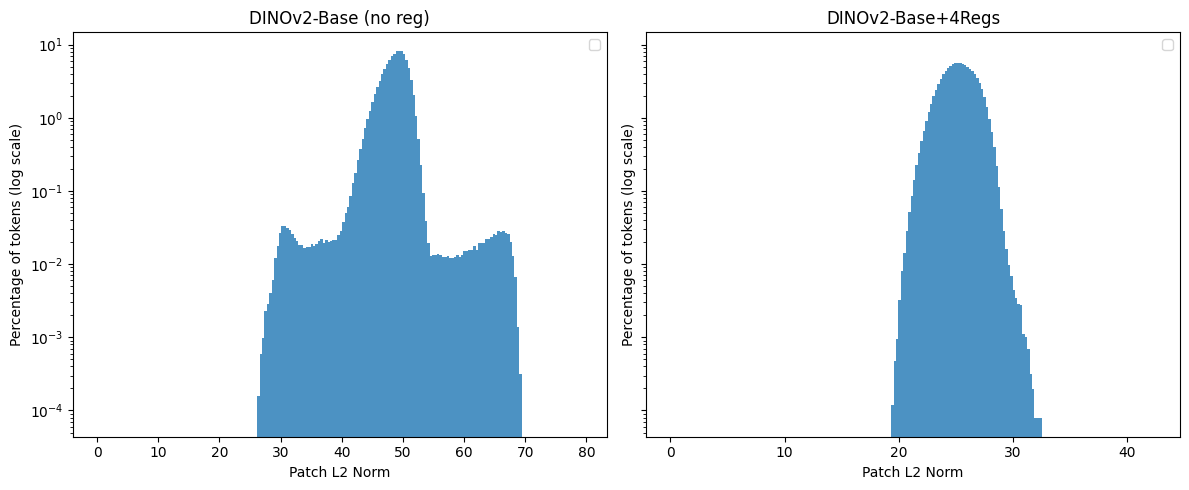

In [5]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
for ax, (name, norms) in zip(axes, [
    ("DINOv2-Base (no reg)", norms_base),
    ("DINOv2-Base+4Regs", norms_reg4)
]):
    mean, std = norms.mean(), norms.std()
    cutoff = mean + 3*std
    ax.hist(
        norms, bins=200,
        range=(0, norms.max()+10),
        weights=np.ones_like(norms)/norms.size*100,
        log=True,
        color="C0", alpha=0.8
    )
    ax.set_title(name)
    ax.set_xlabel("Patch L2 Norm")
    ax.set_ylabel("Percentage of tokens (log scale)")
    ax.legend()

plt.tight_layout()
plt.show()

In [7]:
num_img = 4
max_norms = []
single_loader = DataLoader(val_ds, batch_size=32, shuffle=False,
                        num_workers=0, pin_memory=True)
for idx,(img,label) in enumerate(tqdm(single_loader, desc="Scan images")):
    norm = dinov2_base.forward_features(img.cuda())['x_norm_patchtokens'].norm(dim=-1).max().item()
    max_norms.append((idx,norm))
sorted_max = sorted(max_norms, key=lambda x:x[1], reverse=True)
top_max_norm = [i for i in sorted_max[:num_img]]
print("Top k indices of max norm:", top_max_norm)

Scan images: 100%|██████████| 313/313 [01:38<00:00,  3.18it/s]

Top k indices of max norm: [(69, 69.340087890625), (81, 69.3223876953125), (197, 69.26934814453125), (226, 69.10365295410156)]


ValueError: not enough values to unpack (expected 2, got 1)

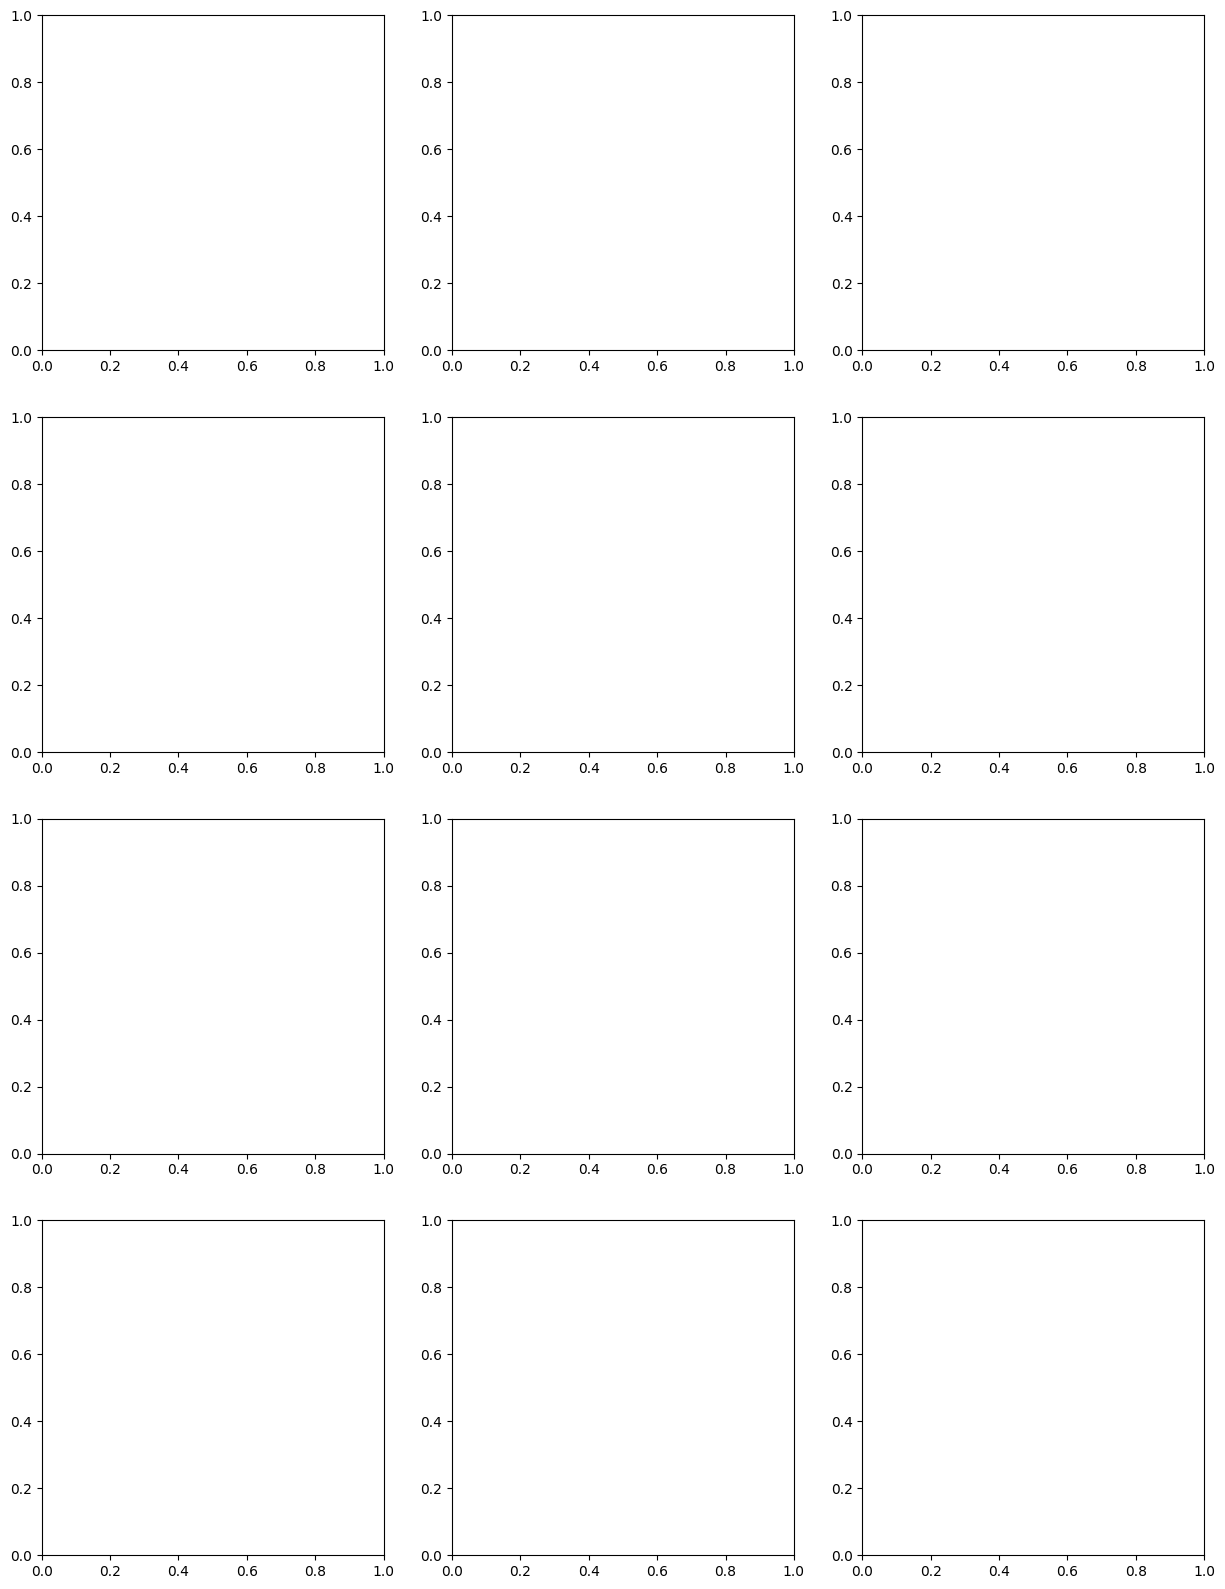

In [12]:
from dinov2.layers import MemEffAttention

# keep a reference to the original forward:
_orig_mefa_forward = MemEffAttention.forward

def _mefa_forward_and_store(self, x, *args, **kwargs):
    """
    Wrap the original forward so that we both get the output
    and capture the attn weights in `self.attn_map`.
    """
    # the real forward returns (output, attn) when you ask for attn
    # so we pass return_attn=True
    out, attn = _orig_mefa_forward(self, x, *args, return_attn=True, **kwargs)
    # stash for later
    self.attn_map = attn
    return out

# patch it in place
MemEffAttention.forward = _mefa_forward_and_store


def get_last_selfattention(model, x):
    """
    Run x through patch‐embed, CLS token, registers, pos‐emb, LN, all blocks,
    and return the last block's attention maps of shape (B, heads, L, L).
    """
    # 1) exactly as prepare_tokens_with_masks
    B,_,H,W = x.shape
    v = model
    # patch‐embed
    x = v.patch_embed(x)                            # (B, n_patches, D)
    # prepend CLS
    cls = v.cls_token.expand(B, -1, -1)             # (B, 1, D)
    x = torch.cat([cls, x], dim=1)                  # (B, 1 + n_patches, D)
    # add pos‐emb
    x = x + v.interpolate_pos_encoding(x, W, H)
    # insert register tokens
    if v.register_tokens is not None:
        regs = v.register_tokens.expand(B, -1, -1)  # (B, R, D)
        x = torch.cat([ x[:, :1], regs, x[:, 1:] ], dim=1)

    # 2) layernorm
    # note: DINOv2 does LN after preparing tokens
    x = v.norm(x)

    # 3) run through each block, capturing the attn from the last one
    attn = None
    for blk in v.blocks:
        # MemEffAttention inside blk returns (x, attn), so we can unpack:
        x, a = blk.attn(x)
        # then run the rest of the block (MLP etc.)
        x = blk.mlp_part(x)
        attn = a  # keep overwriting; at end it'll be from the last layer
    return attn  # shape (B, heads, L, L)

def plot_attention_maps(model, num_reg):
    model = model.eval().to(device)
    n = len(top_max_norm)

    # ensure axes is always 2D
    fig, axes = plt.subplots(n, 3, figsize=(15, 5*n), squeeze=False)

    for row, (idx, norm_val) in enumerate(top_max_norm):
        path, _ = val_ds.samples[idx]
        img = Image.open(path).convert('RGB')
        x = transform(img).unsqueeze(0).to(device)  # [1,3,224,224]

        # 2) forward, ask for attentions
        with torch.no_grad():
            a = get_last_selfattention(model, x)  # (1, heads, L, L)
        cls2patch = a[0,:,0,1:]     # (heads, num_patches)
        cls_map   = cls2patch.mean(0).cpu().numpy().reshape(14,14)

        # 3) make a [0,1] overlay
        normed = (cls_map - cls_map.min())/(cls_map.max()-cls_map.min()+1e-6)
        heat   = Image.fromarray(normed.astype(np.float32), mode='F') \
                      .resize(img.size, Image.BICUBIC)
        overlay = np.array(heat)

        # col 0
        ax0 = axes[row,0]; ax0.imshow(img); ax0.axis('off')
        ax0.set_title(f"idx={idx}, max‐norm={norm_val:.1f}")
        # col 1
        ax1 = axes[row,1]; ax1.imshow(img); ax1.imshow(overlay, cmap='jet', alpha=0.4)
        ax1.axis('off'); ax1.set_title(f"Overlay DINOv2 with {num_reg} Regs")
        # col 2
        ax2 = axes[row,2]; im = ax2.imshow(cls_map, cmap='viridis', interpolation='nearest')
        ax2.axis('off'); ax2.set_title(f"Raw Attn DINOv2 with {num_reg} Regs")
        fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

plot_attention_maps(dinov2_base, 0)
plot_attention_maps(dinov2_reg4, 4)
